### Недообучение и переобучение

#### Цель работы

Познакомиться с основными проблемами обобщающей способности алгоритмов машинного обучения: overfitting (переобучение) и underfitting (недообучение).


#### Задания для выполнения

1. Загрузите первые 400 строк прилагающегося датасета `diabetes.csv`.
2. Сделайте количественное описание датасета: число признаков, статистику по признакам.
3. Отделите целевую переменную `Outcome`.
4. Разделите данные на обучающую и валидационную выборки при помощи `train_test_split` из библиотеки `sklearn.model_selection` в соотношении 80-20 (для этого укажите параметр test_size=0.2) с перемешиванием, указав значение параметра `random_state=42`.
5. Создайте объект `DecisionTreeClassifier(random_state=1)`. Обучите модель на обучающих (трейновых) данных. Сделайте предсказание на трейновом и валидационном наборе признаков. Выведите значения метрики `f1-score`для трейнового и валидационного наборов данных. По полученным значениям метрик сделайте предположение о переобученности модели.
6. Произведите кросс-валидацию с использованием функции `cross_validate` из библиотеки  `sklearn.model_selection`. По полученным данным, постройте график зависимости значений `f1-score` от набора данных соответствующей итерации. По графику убедитесь в том, что имеет место переобученность модели.
7. Для борьбы с переобучением регуляризуйте модель `DecisionTreeClassifier`, уменьшив глубину дерева, указав параметр регуляризации `max_depth=3`.
8. Снова проделайте пункт 6 с учётом регуляризации и убелитесь по графику в том, что модель больше не является переобученной.
9. Теперь рассмотрите проблему недообучения модели. Для борьбы с недообучением модели добавьте данные.
Для этого загрузите все строки датасета `diabetes.csv`.
10. Обучите модель `DecisionTreeClassifier(random_state=1, max_depth=3)` на всех данных и убедитесь в том, что значение метрики `f1-score` улучшилось.



In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

1) Загрузите первые 400 строк прилагающегося датасета diabetes.csv.
2) Сделайте количественное описание датасета: число признаков, статистику по признакам.
3) Отделите целевую переменную Outcome.

In [11]:
data = pd.read_csv('diabetes.csv')
X = data.drop(columns=['Outcome'])  # Все признаки, кроме 'Outcome'
y = data['Outcome']  # Целевая переменная 'Outcome'

num_features = X.shape[1]  # Число признаков
feature_statistics = X.describe()  # Статистика по признакам

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


##### Диагностика моделей классификации

Для первого примера воспользуемся синтетическими данными. Сгенерируем большой датасет для классификации. В нем будет 10 тысяч точек и 500 атрибутов. Из них всего 50 признаков будут информативными. Сразу после генерации разделим получившийся датасет на обучающую и тестовую выборки:


In [12]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=500,
                           n_informative=50, n_repeated=0,
                           class_sep=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

Обучим на этом наборе данных модель логистическую регрессию. Выведем оценки точности этой модели на обучающей и тестовой выборке:

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.8415
Test score: 0.8056


То, насколько отличается обучающая и тестовая эффективность модели - основной индикатор пере- или недообучения. Тестовая эффективность полученной модели неидеальна. Определить, что является причиной снижения качества модели - ее излишняя или недостаточная вариативность - основная цель диагностики модели машинного обучения.

Применим построение кривых обучения. Это даст нам больше информации о том, каков уровень сложности модели по отношению к данным. Воспользуемся готовой реализацией построения кривых обучения из библиотеки продвинутой визуализации для машинного обучения yellowbrick:

/Users/juliamekhtieva/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


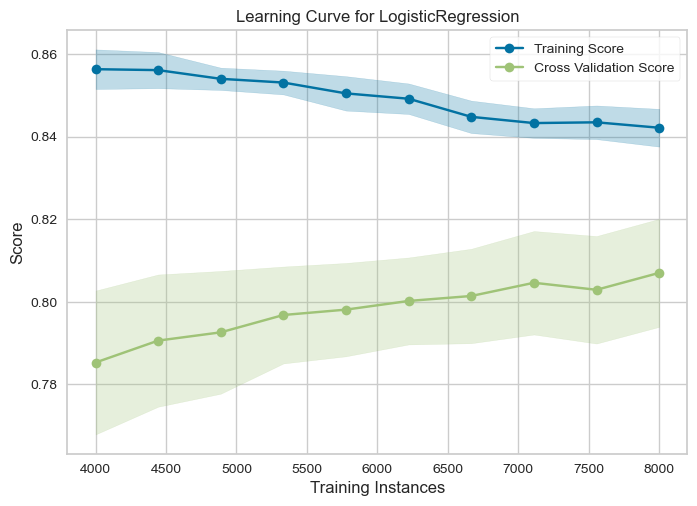

In [16]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(
    LogisticRegression(), train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show()

Задаем модель, которую необходимо проверить и набор долей обучающей выборки. В данном случае, эта функция построит модели логистической регрессии, обученные на 10%, 20%, и так далее до 100% обучающей выборки. А затем по каждой модели будет вычислена обучающая и тестовая эффективности. И эти показатели будут изображены на графике, то есть кривой обучения.

Эта кривая показывает, что когда модель учится на небольшом объеме данных, она имеет прекрасную обучающую эффективность, но плохую тестовую. По мере увеличения объема обучающей выборки, эти эффективности сближаются, но между ними все еще сохраняется зазор.

Большой промежуток между тестовой и обучающей эффективностью свидетельствует о переобучении. А низкое значение обучающей эффективности - о недообучении. 

Воспользуемся классификатором на основе гребневой регрессии. Обычный метод наименьших квадратов (воплощением которого является модель логистической регрессии) эквивалентна гребневой модели с параметром регуляризации, равном нулю. Чем больше этот параметр, тем больше регуляризации в модели и тем проще получаемые модели.

При таком огромном значении регуляризации почти гарантированно получим недообученную модель.


In [18]:
from sklearn.linear_model import RidgeClassifier

lr = RidgeClassifier(alpha=1000000).fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.7724
Test score: 0.7712


Эффективность стала заметно ниже, значения почти совпадают - почти никакой разницы. Это подтверждает первоначальный вывод о том, что в первой модели разница между обучающей и тестовой эффективностью получилась довольно большой для данной задачи. Построим кривые обучения для нашей второй модели:

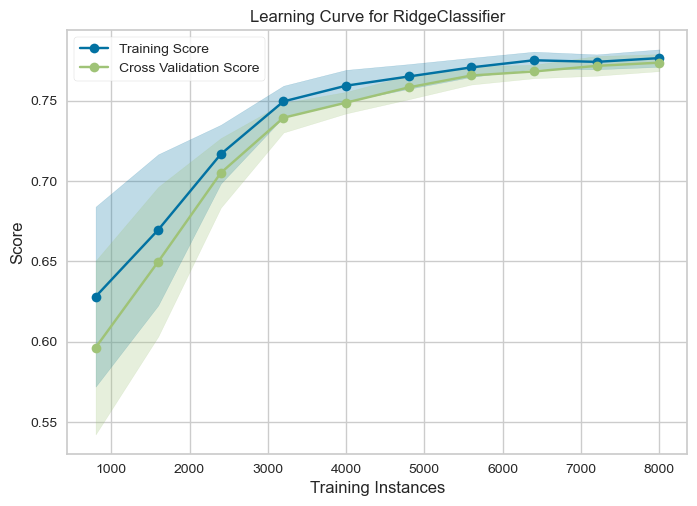

In [20]:
visualizer = LearningCurve(
    RidgeClassifier(alpha=1000000), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y) .show()

Данный график очень характерен для недообучения - низкие значения эффективности и практически никакой разницы между тестовой и обучающей эффективностью.

Построим график зависимости эффективности модели от значения параметра регуляризации. Для этого воспользуется логравномерным распределением:

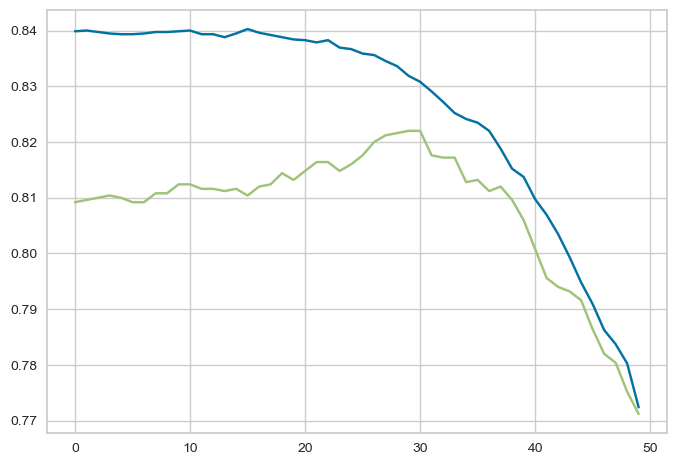

In [21]:
from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
for i in np.logspace(2, 6, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains)
plt.plot(tests)

Данный код построит 50 моделей, различающихся только параметром регуляризации. Он будет лежать в диапазоне от 100 ($10^2$) до 100 000 ($10^6$). Диапазон подбирается эмпирически.